<a href="https://colab.research.google.com/github/ibutin/Innopoilis/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%91%D1%83%D1%82%D0%B8%D0%BD_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение. Постановка целей и задач

Цель этой аттестационной работы - попытаться предсказать поведение акций компании Coca-Cola в следующие 12 мес для принятия решения о среднесрочном инвестировании свободных средств для получения дохода выше депозитного дохода.

### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.7 MB/s 
     |████████████████████████████████| 9.8 MB 54.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
## Здесь импортируем библиотеки и функции 
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Здесь импортируем данные.
df = pd.read_csv('COCO COLA.csv')

### Знакомство с данными.

Этот блок посвящен первоначальному знакомству с данными

Наша задача - посмотреть на данные методами .info(), а также изучить их визуально.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15096 non-null  object 
 1   Open       15096 non-null  float64
 2   High       15096 non-null  float64
 3   Low        15096 non-null  float64
 4   Close      15096 non-null  float64
 5   Adj Close  15096 non-null  float64
 6   Volume     15096 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 825.7+ KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15096.000000,15096.000000,15096.000000,15096.000000,15096.000000,1.509600e+04
mean,16.056202,16.188428,15.921876,16.060734,11.367487,9.032904e+06
std,16.939301,17.064336,16.811753,16.941712,14.253637,7.935744e+06
min,0.192708,0.193359,0.182292,0.192057,0.037855,7.680000e+04
25%,0.860677,0.869792,0.854167,0.860352,0.242312,2.812800e+06
50%,9.328125,9.398438,9.218750,9.351562,4.642848,7.585200e+06
75%,28.875000,29.167500,28.563125,28.901562,17.251080,1.291275e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,1.241690e+08


In [9]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Выводы по данным: пропусков нет - в каждой колонке 15096 значений. 7 колонок: 6 показателей биржевой цены и 1 колонка объема торгов.
Формат цены акций - с плавающей точкой, Объем торгов - целое (это ОК, достаточная точность), а вот формат даты Object потребуется преобразовать

In [10]:
## Добавим новую колонку Date_adj в формате  datetime
df['Date_adj'] = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Date_adj
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400,1962-01-02
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,1962-01-03
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800,1962-01-04
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,1962-01-05
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,1962-01-08


In [11]:
df.dtypes
## Проверяем формат новой колонки - все ОК

Date                 object
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Date_adj     datetime64[ns]
dtype: object

Теперь проблема - для создания временного ряда требуется проиндексировать dataframe по дате - а это не получилось. т.к. есть пропуски дат (выходные, когда нет торгов, праздники и прочее). Кроме того, нам не требуется чуствительность на уровне дней! мы хотим принять решение о среднесрочном инвестировании в производителя напитков. Т.е. Нам достаточно будет уровня значений в каждом месяце

In [16]:
## Преобразуем Дату Date_adj в колонки Год-Мес-день, потом создадим новую колонку только Год-Мес
df['day'] = df['Date_adj'].dt.day
df['month'] = df['Date_adj'].dt.month
df['year'] = df['Date_adj'].dt.year
df['Mth_date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.head()
## Проверим

,Date,Open,High,Low,Close,Adj Close,Volume,Date_adj,day,month,year,Mth_date
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400,1962-01-02,2,1,1962,1962-01-01
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,1962-01-03,3,1,1962,1962-01-01
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800,1962-01-04,4,1,1962,1962-01-01
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,1962-01-05,5,1,1962,1962-01-01
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,1962-01-08,8,1,1962,1962-01-01


Теперь создадим промежуточный dataframe состоящий из агрегат значений по каждому месяцу. В гачестве функции выберем Max 

In [17]:
df2=df.groupby(by=['Mth_date']).max()
df2.head()
## Месяцы по которым агрегировали значения в формате datetime в новом dataframe df2 
##стали индексной колонкой. Есть уверенность что пропусков месяцев нет, но проверим

,Date,Open,High,Low,Close,Adj Close,Volume,Date_adj,day,month,year
Mth_date,,,,,,,,,,,
1962-01-01,1962-01-31,0.263021,0.270182,0.263021,0.263021,0.051133,2649600,1962-01-31,31,1,1962
1962-02-01,1962-02-28,0.247396,0.248698,0.245443,0.247396,0.048095,1420800,1962-02-28,28,2,1962
1962-03-01,1962-03-30,0.257813,0.259766,0.255208,0.257813,0.050446,19545600,1962-03-30,30,3,1962
1962-04-01,1962-04-30,0.251953,0.253906,0.250651,0.252604,0.049427,2227200,1962-04-30,30,4,1962
1962-05-01,1962-05-31,0.250000,0.250977,0.248047,0.250000,0.048917,7411200,1962-05-31,31,5,1962


Уберем лишнюю информацию - оставим только показатели стоимости акций - это будет еще одним промежуточным dataframe df3

In [20]:
df3 = df2.drop(['Date','Adj Close','Date_adj','day','month','year'],1)
df3.head()

,Open,High,Low,Close,Volume
Mth_date,,,,,
1962-01-01,0.263021,0.270182,0.263021,0.263021,2649600
1962-02-01,0.247396,0.248698,0.245443,0.247396,1420800
1962-03-01,0.257813,0.259766,0.255208,0.257813,19545600
1962-04-01,0.251953,0.253906,0.250651,0.252604,2227200
1962-05-01,0.250000,0.250977,0.248047,0.250000,7411200


In [22]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 1962-01-01 to 2021-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    720 non-null    float64
 1   High    720 non-null    float64
 2   Low     720 non-null    float64
 3   Close   720 non-null    float64
 4   Volume  720 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 33.8 KB


### Построим график dataframe df3

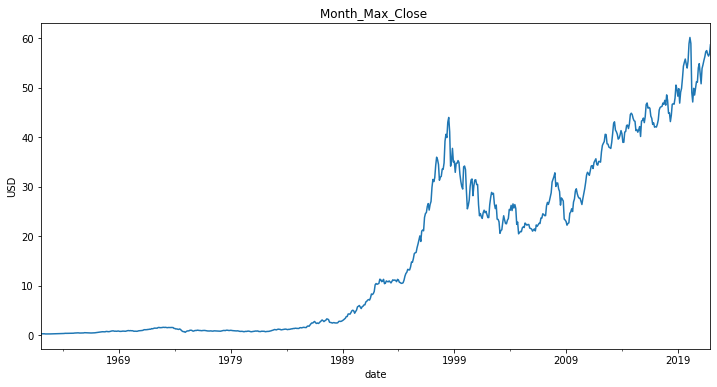

In [26]:
title = 'Month_Max_Close '
ylabel='USD'
xlabel='date' 

ax = df3['Close'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Очевидно, что этот набор данных "от царя гороха" не требуется в таком объеме. для анализа тренда оставим только данные за последние 10 лет. Это и будет финальный dataframe для последующего прогнозирования

In [38]:
df_final=df3.tail(120)
df_final.head()

,Open,High,Low,Close,Volume
Mth_date,,,,,
2012-01-01,35.075001,35.355000,35.049999,35.070000,23428800
2012-02-01,34.674999,34.990002,34.459999,34.930000,24269600
2012-03-01,36.810001,37.195000,36.654999,37.005001,41063600
2012-04-01,38.209999,38.910000,37.965000,38.314999,26517600
2012-05-01,38.680000,38.869999,38.599998,38.735001,31913000


### Построим график dataframe df_final

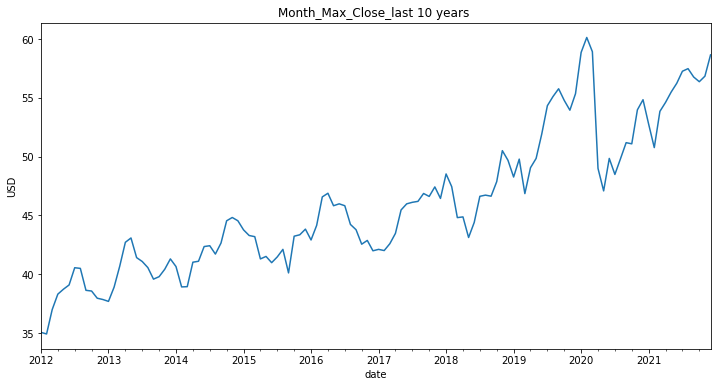

In [41]:
title = 'Month_Max_Close_last 10 years '
ylabel='USD'
xlabel='date' 

ax = df_final['Close'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### ETS декомпозиция

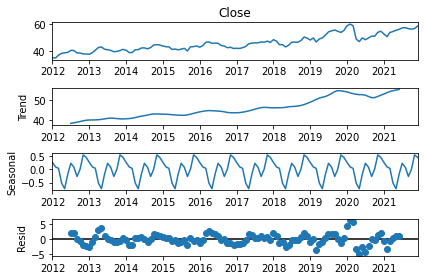

In [39]:
result = seasonal_decompose(df_final['Close'], model='add')
result.plot();

Несмотря на небольшой масштаб по сравнению с общими значениями, существует крошечная годовая сезонность.

### Запускаем <tt>pmdarima.auto_arima</tt>

In [40]:
# m=12
auto_arima(df_final['Close'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -214.961
Date:                              Tue, 22 Mar 2022   AIC                            445.921
Time:                                      17:12:20   BIC                            468.154
Sample:                                           0   HQIC                           454.949
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0130      0.023      0.553      0.580      -0.033       0.059
ar.L1          0.7843      0.349      2.250      0.024       0.101       1.468
ar.L2         -0.0781      0.296     -0.264      0.792      -0.658       0.502
ma.L1         -0.7127      0.329     -2.168      0.030      -1.357      -0.068
ma.L2         -0.2546      0.340     -0.749      0.454      -0.921       0.412
ar.S.L12       0.7288      0.456      1.599      0.110      -0.164       1.622
ma.S.L12      -0.8716      0.475     -1.834      0.067      -1.803       0.060
sigma2         2.1546      0.418      5.152      0.000       1.335       2.974
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               211.30
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               4.75   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### делим на train/test 

In [42]:
len(df_final)

120

In [72]:
# 
train = df_final.iloc[100:110]
test = df_final.iloc[110:]


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2020-05-01 to 2021-02-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    10 non-null     float64
 1   High    10 non-null     float64
 2   Low     10 non-null     float64
 3   Close   10 non-null     float64
 4   Volume  10 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 480.0 bytes


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2021-03-01 to 2021-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    10 non-null     float64
 1   High    10 non-null     float64
 2   Low     10 non-null     float64
 3   Close   10 non-null     float64
 4   Volume  10 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 480.0 bytes


### Обучаем SARIMA (1, 1, 2)x(2, 0, 2, 12)

In [75]:
# (1, 1, 2)x(2, 0, 2, 12)
model = SARIMAX(train['Close'], order=(1, 1, 2), seasonal_order=(2, 0, 2, 12) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   10
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 -17.619
Date:                            Tue, 22 Mar 2022   AIC                             51.238
Time:                                    18:37:37   BIC                             52.816
Sample:                                05-01-2020   HQIC                            47.833
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4679      6.347     -0.074      0.941     -12.908      11.973
ma.L1          0.7808     53.659      0.015      0.988    -104.389     105.951
ma.L2         -0.2112     10.771     -0.020      0.984     -21.322      20.900
ar.S.L12       0.2774   9.71e+04   2.86e-06      1.000    -1.9e+05     1.9e+05
ar.S.L24       0.6726   9.08e+04    7.4e-06      1.000   -1.78e+05    1.78e+05
ma.S.L12       0.8902   2.56e+05   3.48e-06      1.000   -5.02e+05    5.02e+05
ma.S.L24       0.7395   7.15e+04   1.03e-05      1.000    -1.4e+05     1.4e+05
sigma2         0.0630   4091.345   1.54e-05      1.000   -8018.826    8018.952
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.66   Prob(JB):                         0.67
Heteroskedasticity (H):               0.44   Skew:                            -0.11
Prob(H) (two-sided):                  0.51   Kurtosis:                         1.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.1e+17. Standard errors may be unstable.
"""

In [76]:
# предсказанные значения
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1, 1, 2)x(2, 0, 2, 12) ')

In [77]:
# Сравниваем результаты
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.4}, expected={test['Close'][i]:<11.4}")

predicted=51.36      , expected=53.85      
predicted=50.66      , expected=54.61      
predicted=51.37      , expected=55.49      
predicted=54.07      , expected=56.24      
predicted=52.74      , expected=57.26      
predicted=54.05      , expected=57.48      
predicted=55.38      , expected=56.77      
predicted=55.29      , expected=56.37      
predicted=58.11      , expected=56.84      
predicted=58.96      , expected=58.65      


Строим графики

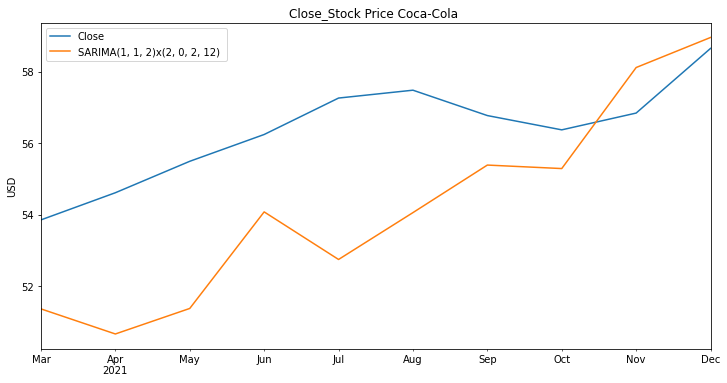

In [78]:
# графики
title = 'Close_Stock Price Coca-Cola '
ylabel='USD'
xlabel=''

ax = test['Close'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Оценка модели

In [79]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Close'], predictions)
print(f'SARIMA(1, 1, 2)x(2, 0, 2, 12) MSE Error: {error:11.5}')

SARIMA(1, 1, 2)x(2, 0, 2, 12) MSE Error:      8.0443


In [80]:
from statsmodels.tools.eval_measures import rmse
# rmse = root mse
error = rmse(test['Close'], predictions)
print(f'SARIMA(1, 1, 2)x(2, 0, 2, 12) RMSE Error: {error:11.10}')

SARIMA(1, 1, 2)x(2, 0, 2, 12) RMSE Error: 2.836241292


RMSE около 3 USD, это много для принятия решения, но посмотрим каким будет прогноз. Если положительным (рост акций) - вернемся к вопросу RMSE


### Обучаем модель на полных данных и прогнозируем будущее :)

In [81]:
# (1, 1, 2)x(2, 0, 2, 12)
model = SARIMAX(df_final['Close'],order=(1, 1, 2),seasonal_order=(2, 0, 2, 12))
results = model.fit()

fcast = results.predict(len(df_final),len(df_final)+12,typ='levels').rename('SARIMA(1, 1, 2)x(2, 0, 2, 12) Forecast')


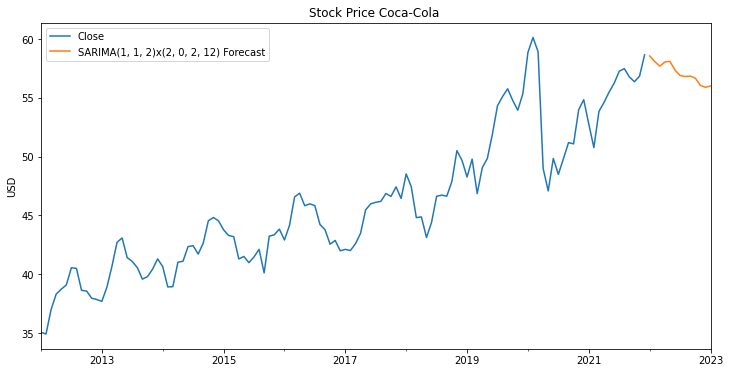

In [82]:
# график
title = 'Stock Price Coca-Cola '
ylabel='USD'
xlabel=''

ax = df_final['Close'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Вывод: в результате исследования построена модель прогнозирования стоимости акций. Результат прогноза - падение стоимости, т.е. среднесрочное инвестирование нецелесообразно